# Retention analysis for Sequoia Data Science Team
Wells Wulsin
13 Aug 2023


## Stage 1:  Data import
We get a warning because the boolean columns have some NaN values. We will address this in the cleaning stage below. 

In [748]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [749]:
# We cannot apply the schema yet because some columns have NaN values
# col_types = {
#     'oid': 'string',
#     'provider': 'string',
#     'total_charges': 'float64',
#     'signup_date': 'string',
#     'is_canceled': 'bool',
#     'is_active': 'bool',
#     'is_delinquent': 'bool',
#     'conversion_date': 'string',
#     'cancellation_date': 'string',
#     'current_mrr': 'float64',
#     'personal_person_geo_country': 'string',
#     'converted': 'bool'
# }
df = pd.read_csv('dummy_customer_file.csv')



/tmp/ipykernel_16748/3525752252.py:16: DtypeWarning: Columns (4,5,6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dummy_customer_file.csv')


## Stage 2: Data cleaning

Investigate each column and clean as needed. 

In [750]:
df.dtypes

oid                             object
provider                        object
total_charges                  float64
signup_date                     object
is_canceled                     object
is_active                       object
is_delinquent                   object
conversion_date                 object
cancellation_date               object
current_mrr                    float64
personal_person_geo_country     object
converted                       object
dtype: object

In [751]:
df.head(3)


,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,personal_person_geo_country,converted
0,273624174263463,apple,10.94,2021-04-20,True,False,False,2021-04-20,2021-05-20T12:00:00.000+00:00,0.0,France,True
1,532534633483904,apple,10.92,2021-04-20,True,False,False,2021-04-20,2021-06-20T12:00:00.000+00:00,0.0,United Kingdom of Great Britain and Northern I...,True
2,623527156674739,apple,0.00,2021-04-20,False,False,False,NaN,NaN,0.0,Germany,False


In [752]:
num_rows = len(df)
print(f"The number of rows in the dataframe is: {num_rows}")

The number of rows in the dataframe is: 134612


### Clean oid

Steps: 
  1. Check the number of unique values. 
  1. Look at rows with a null oid. Since all the other columns are also null we can safely remove them. 
  1. Look at rows with duplicate oid values. There are only 6 oid values that are duplicated, out of 134602 total, and such a small fraction (0.004%) is unlikely to significantly affect the conclusions of a retention analysis. But for the sake of completeness we should make a decision about how to handle them. Normally we should consult with a subject matter expert to understand the root cause of these duplicates. In this case without access to an SME, I will make an assumption that the most correct information for each oid comes from the row with the largest value of total_charges (perhaps the other rows were generated at an earlier date and thus represent only partial information about the customer's total payments). So in the case of duplicate oid values, we will retain in the original dataframe only the row with the largest value of total_charges. 

In [753]:
df['oid'].nunique()

134602

In [754]:
print(df[df['oid'].isnull()])

       oid  provider  total_charges signup_date is_canceled is_active  \
134610  NaN  NaN     NaN             NaN         NaN         NaN        
134611  NaN  NaN     NaN             NaN         NaN         NaN        

       is_delinquent conversion_date cancellation_date  current_mrr  \
134610  NaN           NaN             NaN              NaN            
134611  NaN           NaN             NaN              NaN            

       personal_person_geo_country converted  
134610  NaN                         NaN       
134611  NaN                         NaN       


In [755]:
df = df.dropna(subset=['oid'])

In [756]:
duplicates = df[df['oid'].duplicated(keep=False)]
print("Number of duplicate rows:", duplicates['oid'].nunique())
print("Duplicate rows:")
print(duplicates.sort_values(by='oid'))


Number of duplicate rows: 6
Duplicate rows:
      oid        provider  total_charges signup_date is_canceled is_active  \
69649  1.484E+15  apple     7.99          2022-06-23   True       False      
69742  1.484E+15  apple    55.93          2022-06-23  False        True      
69774  1.484E+15  apple    59.99          2022-06-23  False        True      
71059  1.561E+15  apple    62.56          2022-06-29  False        True      
71298  1.561E+15  apple    59.99          2022-06-30  False        True      
65207  1.645E+15  apple    60.32          2022-06-01  False        True      
65223  1.645E+15  apple     0.00          2022-06-01  False       False      
59545   1.68E+15  apple    71.91          2022-05-04  False        True      
59747   1.68E+15  apple     0.74          2022-05-05  False        True      
59783   1.68E+15  apple    59.99          2022-05-05  False        True      
59645  1.736E+15  apple     0.00          2022-05-04  False       False      
59670  1.736E+15  ap

In [757]:
deduped = df.groupby('oid')['total_charges'].max().reset_index()
df = df.merge(deduped, on=['oid', 'total_charges'], how='inner')
print("Number of rows:", len(df))
print("Number of unique oid values:", df['oid'].nunique())

Number of rows: 134602
Number of unique oid values: 134602


### Clean provider
No cleaning is needed for the provider column. All the rows have values of "apple", "stripe", or "google". 

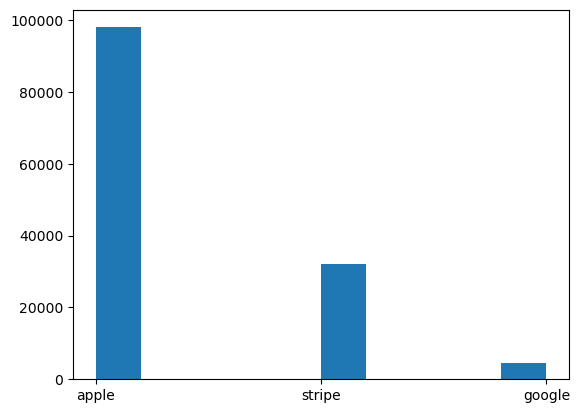

In [758]:
df['provider'].hist(grid=False)
plt.show()


### Clean total_charges
First check whether there are any null values and find there are none. Then plot a histogram and get the minimum and maximum values to make sure they are not unreasonable. As expected, there is a spike at 0 corresponding to customers who have not yet subscribed. We find the maximum charge to be 293.58, which is reasonable for a subscription product. The minimum charge is -119.98, which could also be reasonable if there are instances where a customer gets a refund for a special promotion. Normally we should confirm with SMEs that these negative charges are expected, but for this exercise we will assume that they are part of normal operation and thus can be retained in the analysis.  

In [759]:
df[df['total_charges'].isnull()]

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,personal_person_geo_country,converted


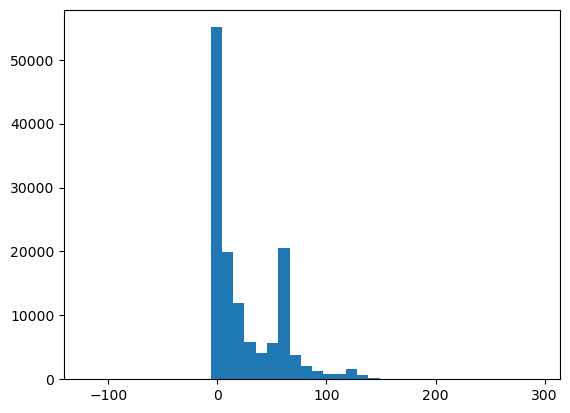

In [760]:
df['total_charges'].hist(bins=40, grid=False)
plt.show()

In [761]:
df['total_charges'].max()

293.58

In [762]:
df['total_charges'].min()

-119.98

### Clean signup_date
To perform date-related computations we need to cast this column to type datetime. Next we check for null values to ensure that all of the rows were cast appropriately. Then make a distribution of the signup dates, which shows the first signup was in April 2021, and the last signup was in January 2023. 

In [763]:
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [764]:
df['signup_date'].isnull().sum()

0

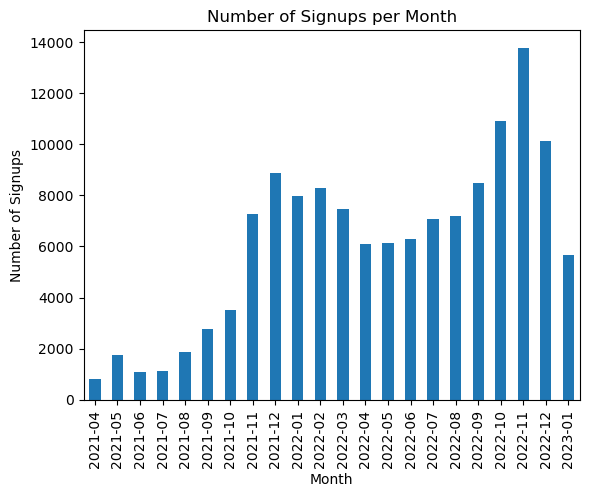

In [765]:
monthly_counts = df.groupby(df['signup_date'].dt.to_period('M')).size().reset_index(name='count')
monthly_counts.plot(x='signup_date', y='count', kind='bar', legend=None)
plt.xlabel('Month')
plt.ylabel('Number of Signups')
plt.title('Number of Signups per Month')
plt.show()


### Clean is_canceled, is_active, is_delinquent, converted
Convert these columns to bool's. 



In [766]:
df['is_canceled'] = df['is_canceled'].astype(bool)
df['is_active'] = df['is_active'].astype(bool)
df['is_delinquent'] = df['is_delinquent'].astype(bool)
df['converted'] = df['converted'].astype(bool)

In [767]:
df['is_canceled'].value_counts()

False    101173
True      33429
Name: is_canceled, dtype: int64

In [768]:
df['is_active'].value_counts()

False    87537
True     47065
Name: is_active, dtype: int64

In [769]:
df['is_delinquent'].value_counts()

False    134512
True         90
Name: is_delinquent, dtype: int64

In [770]:
df['converted'].value_counts()

True     80753
False    53849
Name: converted, dtype: int64

### Clean conversion_date
Convert from string to datetime. 
Confirm there are no null values of conversion_date when converted is True. 
Plot the distribution of conversion dates, which shows they range from April 2021 to January 2023.

In [771]:
df['conversion_date'] = pd.to_datetime(df['conversion_date'])

In [772]:
df[df['converted']]['conversion_date'].isnull().sum()

0

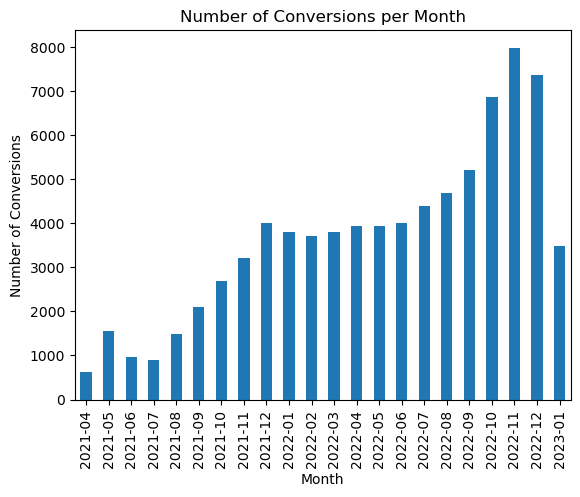

In [773]:
monthly_counts = df.groupby(df['conversion_date'].dt.to_period('M')).size().reset_index(name='count')
monthly_counts.plot(x='conversion_date', y='count', kind='bar', legend=None)
plt.xlabel('Month')
plt.ylabel('Number of Conversions')
plt.title('Number of Conversions per Month')
plt.show()

### Clean cancellation_date
Convert the string to a datetime. 
Confirm that cancellation_date is never null when is_canceled is True.
Plot the monthly count of cancellations, which shows they range from May 2021 to January 2023. 

In [774]:
df['cancellation_date'] = pd.to_datetime(df['cancellation_date']).dt.tz_localize(None)

In [775]:
df[df['is_canceled']]['cancellation_date'].isnull().sum()

0

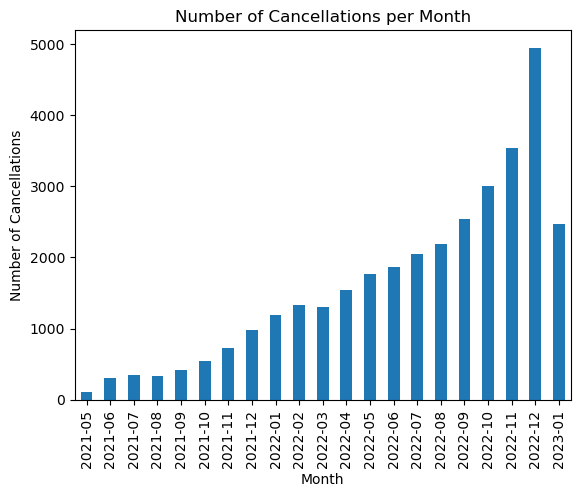

In [776]:
monthly_counts = df.groupby(df['cancellation_date'].dt.to_period('M')).size().reset_index(name='count')
monthly_counts.plot(x='cancellation_date', y='count', kind='bar', legend=None)
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.title('Number of Cancellations per Month')
plt.show()

### Clean current_mrr
Confirm that current_mrr is never null, because customers who have never subscribed should have a value of 0, not null. 
Plot the distribution, which shows that the most common MRR is about 5, wihle the maximum is 23.14. 

In [777]:
df['current_mrr'].isnull().sum()

0

In [778]:
df['current_mrr'].max()

23.14

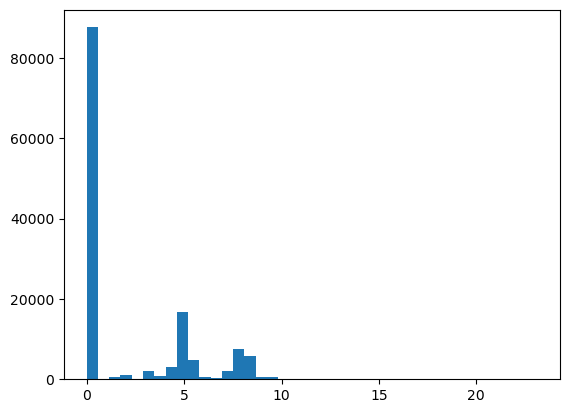

In [779]:
df['current_mrr'].hist(bins=40, grid=False)
plt.show()

### Clean personal_person_geo_country
First, check for null values. There are 29107 customers with a null value for personal_person_geo_country. I reassign these to "Unknown" for clarity and to allow string replacement in a subsequent step. 

Next I get the list of all countries and the number of customers associated with each one. To harmonize country names I used my best interpretation. For example I reclassified Reunion as France, based on https://en.wikipedia.org/wiki/R%C3%A9union. There are 13 country names that are reassigned to a new harmonized name. 

Ideally we would implement a standardized set of country names in the source system to avoid potential data irregularities in the future. 

I also renamed this column to be "country" to shorten the code. 

In [780]:
pd.set_option('display.max_rows', 200)

In [781]:
df = df.rename(columns={'personal_person_geo_country': 'country'})

In [782]:
df['country'].isnull().sum()

29107

In [783]:
df['country'] = df['country'].fillna('Unknown')

In [784]:
df['country'].isnull().sum()

0

In [785]:
countries = df.groupby('country')['oid'].agg('count').reset_index().rename(columns={'oid': 'count'})
countries = countries.style.set_properties(**{'text-align': 'left'})
display(countries)

,country,count
0,Albania,34
1,Algeria,6
2,Anguilla,1
3,Antarctica,1
4,Argentina,227
5,Armenia,50
6,Aruba,1
7,Australia,3105
8,Austria,900
9,Azerbaijan,34


In [786]:
conditions = []
values = []
conditions.append(df['country'].str.contains('Bahamas')); values.append('Bahamas')
conditions.append(df['country'].str.contains('Bolivia')); values.append('Bolivia')
conditions.append(df['country'].str.contains('Korea \(Republic of\)')); values.append('South Korea')
conditions.append(df['country'].str.contains('Macedonia \(FYROM\)')); values.append('North Macedonia')
conditions.append(df['country'].str.contains('Russia')); values.append('Russia')
conditions.append(df['country'].str.contains('Réunion')); values.append('France')  # see https://en.wikipedia.org/wiki/R%C3%A9union
conditions.append(df['country'].str.contains('Taiwan')); values.append('Taiwan')
conditions.append(df['country'].str.contains('Türkiye')); values.append('Taiwan')
conditions.append(df['country'].str.contains('United Kingdom')); values.append('United Kingdom')
conditions.append(df['country'].str.contains('United States')); values.append('United States')
conditions.append(df['country'].str.contains('Virgin Islands \(U.S.\)')); values.append('United States')
conditions.append(df['country'].str.contains('Venezuela')); values.append('Venezuela')
conditions.append(df['country'].str.contains('Viet Nam')); values.append('Vietnam')
df['country_new'] = np.select(conditions, values, default=None)
df['country'] = np.where(df['country_new'], df['country_new'], df['country'])
df = df.drop('country_new', axis=1)

In [787]:
countries = df.groupby('country')['oid'].agg('count').reset_index().rename(columns={'oid': 'count'})
countries = countries.style.set_properties(**{'text-align': 'left'})
display(countries)

,country,count
0,Albania,34
1,Algeria,6
2,Anguilla,1
3,Antarctica,1
4,Argentina,227
5,Armenia,50
6,Aruba,1
7,Australia,3105
8,Austria,900
9,Azerbaijan,34


In [788]:
pd.set_option('display.max_rows', 10)

In [789]:
df['country'].value_counts()

United States     40223
Unknown           29107
United Kingdom     8797
Germany            8362
France             4302
                  ...  
Niger                 1
Somalia               1
Eswatini              1
Antarctica            1
Seychelles            1
Name: country, Length: 159, dtype: int64

## Stage 3: Retention analysis

## Define new columns
In order to perform a retention analysis I need to introduce some new columns


In [790]:
df.head()

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,country,converted
0,273624174263463,apple,10.94,2021-04-20,True,False,False,2021-04-20,2021-05-20 12:00:00,0.00,France,True
1,532534633483904,apple,10.92,2021-04-20,True,False,False,2021-04-20,2021-06-20 12:00:00,0.00,United Kingdom,True
2,623527156674739,apple,0.00,2021-04-20,False,False,False,NaT,NaT,0.00,Germany,False
3,441616357320658,apple,90.30,2021-04-20,False,True,False,2021-04-27,NaT,3.47,Switzerland,True
4,189644194376891,apple,79.98,2021-04-20,False,True,False,2021-05-04,NaT,3.33,United States,True


In [791]:
df['signup_cohort_month'] = df['signup_date'].dt.to_period('M')
df['conversion_cohort_month'] = df['conversion_date'].dt.to_period('M')

In [792]:
pd.set_option('display.max_rows', 30)

In [793]:
df['signup_cohort_month'].value_counts()

2022-11    13795
2022-10    10929
2022-12    10144
2021-12     8884
2022-09     8472
2022-02     8302
2022-01     7998
2022-03     7466
2021-11     7258
2022-08     7209
2022-07     7072
2022-06     6275
2022-05     6144
2022-04     6116
2023-01     5653
2021-10     3519
2021-09     2765
2021-08     1848
2021-05     1747
2021-07     1129
2021-06     1069
2021-04      808
Freq: M, Name: signup_cohort_month, dtype: int64

In [794]:
df['today'] = pd.Timestamp.today()

In [795]:
df['last_active_date'] = np.where(df['is_active'], df['today'], df['cancellation_date'])
df['last_paid_date'] = np.where(~df['is_canceled'], df['today'], df['cancellation_date'])

In [796]:
df['lifetime_months'] = df.apply(
    lambda row: relativedelta(row['last_active_date'], row['signup_date']).months +
                relativedelta(row['last_active_date'], row['signup_date']).years * 12
                if pd.notnull(row['signup_date']) and pd.notnull(row['last_active_date'])
                else np.nan, axis=1)
df['revenue_months'] = df.apply(
    lambda row: relativedelta(row['last_paid_date'], row['conversion_date']).months +
                relativedelta(row['last_paid_date'], row['conversion_date']).years * 12
                if pd.notnull(row['conversion_date']) and pd.notnull(row['last_paid_date'])
                else np.nan, axis=1)


### Chart: Delinquency by cohort

In [797]:
del_den = df[df['converted']].groupby('conversion_cohort_month')['oid'].agg('count').reset_index().rename(columns={'oid': 'total'})
del_num = df[(df['converted'] & df['is_delinquent'])].groupby('conversion_cohort_month')['oid'].agg('count').reset_index().rename(columns={'oid': 'delinquent'})

In [798]:
dfdel = del_den.merge(del_num, on='conversion_cohort_month', how='left')
dfdel = dfdel.fillna(0.0)

In [799]:
dfdel['delinquency_rate'] = dfdel['delinquent'] / dfdel['total']

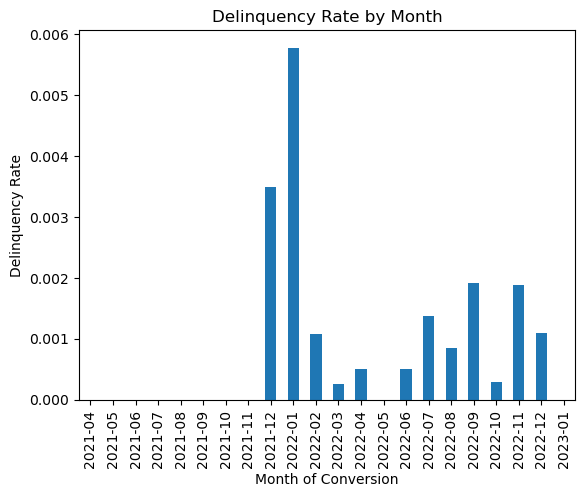

In [800]:
dfdel.set_index('conversion_cohort_month', inplace=True)
dfdel['delinquency_rate'].plot(kind='bar')
plt.xlabel('Month of Conversion')
plt.ylabel('Delinquency Rate')
plt.title('Delinquency Rate by Month')
plt.show()


### Chart:  Revenue expansion
Evaluate revenue expansion based on the whether the current MRR for a given customer is greater than that customer's average monthly payment since they converted. 

The calculation is: 
rev_growth_ratio = current_mrr / (total_charges/revenue_months)

A rev_growth_ratio greater than 1.0 indicates revenue expansion over the time period when the customer has been paying. 

In [841]:
df['rev_growth_ratio'] = np.where(df['total_charges'], df['current_mrr'] / df['total_charges'] * df['revenue_months'], 1.0)

In [857]:
dfgrowth = df[df['converted'] & (df['total_charges'] > 0)]
dfgrowth = dfgrowth.groupby('conversion_cohort_month')['rev_growth_ratio'].mean().reset_index()
dfgrowth.set_index('conversion_cohort_month', inplace=True)

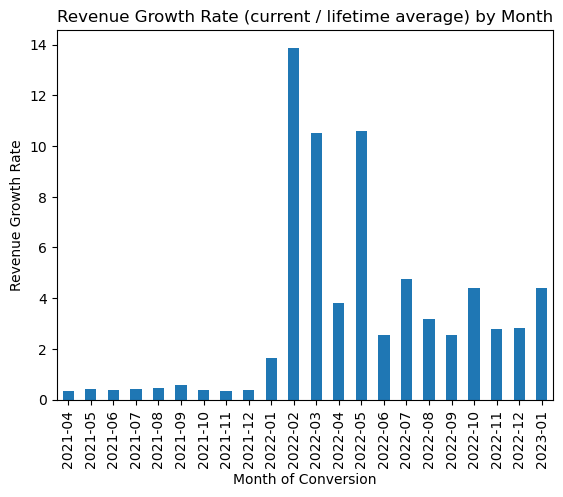

In [858]:
dfgrowth['rev_growth_ratio'].plot(kind='bar')
plt.xlabel('Month of Conversion')
plt.ylabel('Revenue Growth Rate')
plt.title('Revenue Growth Rate (current / lifetime average) by Month')
plt.show()